# Week 08 - Topic Modeling - Latent Dirichlet Allocation

------

In [27]:
# from IPython.display import HTML
# HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/DTl5Xetaprw" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Welcome back! Today, we'll work on a very useful text analysis technique called Topic Modeling. Particularly, we will use its most popular and powerful algorithm: Latent Dirichlet Allocation, or LDA

Before you implement your own LDA on Pyro, it is important that you understand all concepts well. In this notebook, we'll start by playing a little bit with the Dirichlet distribution. After this, we'll ask you to do some ancestral sampling on the LDA generative story.

Only after that, you'll do your own LDA in Pyro. 


We start by the usual imports

In [28]:
# !pip install pyro-ppl

In [29]:
import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1 - Understanding the dirichlet distribution

The Dirichlet distribution is available as numpy.random.dirichlet(alpha, size=None)

...so, try it! For example, obtain draws from this distribution using different values of alpha.

In [31]:
print(np.random.dirichlet([.2,.2, .2]))
print(np.random.dirichlet([.1,.1, .9]))
print(np.random.dirichlet([1,1, 1]))

[0.05949551 0.4820477  0.45845678]
[1.50423128e-08 1.33921258e-11 9.99999985e-01]
[0.05953781 0.91067193 0.02979026]


Check that the sum is always 1, for all vectors...

In [32]:
np.sum(np.random.dirichlet([.2,.2, .2]))

0.9999999999999999

Whenever you can, try to visualize it. Remember what we did in the slides. Try to do the same thing!

**feel free to use the function below, to plot points from a dirichlet distribution, onto a 2D simplex**

In [33]:
'''Function to plot points in a simplex'''

# Based on post from Thomas Boggs (http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/)

import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

def plot_points(X):
    '''Plots a set of points in the simplex.

    Arguments:

        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
    '''
    
    X = X.dot(_corners)  #This is what converts the original points onto the simplex (it projects on it, through dot product)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)

Generate 10000 points from the dirichlet distribution and plot them using the function above

In [34]:
points = np.random.dirichlet([.9, .9, .9], size=10000)

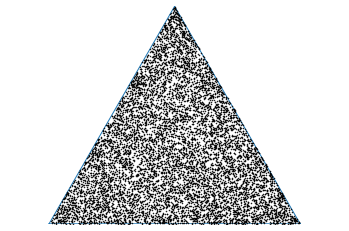

In [35]:
plot_points(points)

Try with different values of $\alpha$

Notice that $\alpha = [1,1,1]$ corresponds to a uniform distribution. Values of $\alpha < 1$ lead to sparse distributions (can be used as sparsity-inducing priors!). The higher the value of $\alpha$, the more concentrated is the distribution.

----------------

## Part 2: LDA Ancestral Sampling

In [36]:
# HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/C-8hgB-JQl4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

We define our own dictionary of 30 words. There are 3 different topics that we embedded in the dictionary, can you see what they are?

In [37]:
K = 3
dictionary =["Copenhagen",
             "Madrid",
             "Sydney",
             "Kabul",
             "Vienna",
             "Brussels",
             "Beijing",
             "Kathmandu",
             "Singapore",
             "Oslo",
             "blue",
             "green",
             "beige",
             "cyan",
             "black",
             "tan",
             "brown",
             "orange",
             "white",
             "red",
             "data",
             "model",
             "inference",
             "learning",
             "observation",
             "dimension",
             "training",
             "neuralnetwork",
             "analytics",
             "sampling"
             ]
C = len(dictionary)

To make it smoother and more fun, we'll start by giving you the topics, $\phi$ and the proportions $\theta$ directly. I.e., you don't need to generate (yet) those from Dirichlet distribution.

Lets start by defining the 3 topics. We do this by assigning a probability for each word under of the 3 topics ($\phi$).

In [38]:
## Define word vectors (for each topic) and normalize:
phi = np.zeros( (K, C) );
phi[0] = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[0] *= 1/np.sum(phi[0])
phi[1] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[1] *= 1/np.sum(phi[1])
phi[2] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
phi[2] *= 1/np.sum(phi[2])

Notice that for topic 1, we assigned high probability to the words: Copenhagen, Madrid, Sydney, Kabul, Vienna, Brussels, Beijing, Kathmandu, Singapore, Oslo. 

Similarly, for topic 2, we assigned high probability to the words: blue, green, ...

Finaly, for topic 3, we assigned high probability to the words: model, inference, ...

Now that we have defined the probability of each word under each topic, we can follow the generative process to sample some documents. As previously mentioned, we will pre-define the distribution over topics for each document ($\theta$):

In [39]:
I = 3 ## Number of documents.

## Define topic proportion vectors (one for for each document):
theta = np.zeros( (I, K) );
theta[0] = [0.6, 0.2, 0.2]
theta[1] = [1/3, 1/3, 1/3] ## This one will be an equal mix of all topics
theta[2] = [  0,   0,  1] ## This will for example only contain topic 3.

Notice that the first document has higher probability of containing words from topic 1 than topics 2 and 3. Document 2 is uniform - all topics have equal probability. Document 3 covers exclusevely topic 3.

Let us now generate the 3 documents following the generative process:

So, you assume now that we have $\boldsymbol{\theta}_i$ for all documents and $\boldsymbol{\phi}_k$ for all topics. Ancestral sampling is simply:


For each document $i$, and for each word $j=1...w_i$, do:
\begin{align}
z_{i, j} &\sim Cat(\boldsymbol{\theta}_i) \\
w_{i, j} &\sim Cat(\boldsymbol{\phi}_{z_{i,j}})
\end{align}



Can you try code it down yourself?

In [40]:
##Just to make things practical, we created this function for you
## just read it or, try it, to see what it does...
def categorical_sample(p):
    return list(np.random.multinomial(1, p)).index(1)

In [41]:
## function that receives document sizes J, theta (topic proportions) and phi (topics), 
## returns z (word-topic assignments ) and w (words)
def ancestral_sampling(J, theta, phi):
    ## Initialise
    z = np.zeros( (I, np.max(J)), dtype=int )  #NOTICE that z and w are vectors of integers!
    w = np.zeros( (I, np.max(J)), dtype=int )  

    for i in range(I):
        for j in range(J[i]):
            z[i,j] = int(categorical_sample(theta[i]))
            w[i,j] = categorical_sample(phi[z[i,j]])
    
    return z, w

In [42]:
J = [12, 9, 10] ## Vector of size I denoting how many words are in each document
z, w = ancestral_sampling(J, theta, phi)
print("w:", w)
for i in range(I):
    print("\n\nDocument: ", i)
    print("Theta: ", theta[i])
    for j in range(J[i]):
        print("Word %d: Topic assignment: %d->   %s  " % (j,  z[i, j]+1, dictionary[w[i, j]]))

w: [[29 12 14  4  3  9  5 22 26 21 19  5]
 [20  3 13 21 29  0 18  3 16  0  0  0]
 [21 20 21 28 22 29 20 23 21 20  0  0]]


Document:  0
Theta:  [0.6 0.2 0.2]
Word 0: Topic assignment: 1->   sampling  
Word 1: Topic assignment: 2->   beige  
Word 2: Topic assignment: 2->   black  
Word 3: Topic assignment: 1->   Vienna  
Word 4: Topic assignment: 1->   Kabul  
Word 5: Topic assignment: 1->   Oslo  
Word 6: Topic assignment: 1->   Brussels  
Word 7: Topic assignment: 3->   inference  
Word 8: Topic assignment: 3->   training  
Word 9: Topic assignment: 3->   model  
Word 10: Topic assignment: 2->   red  
Word 11: Topic assignment: 1->   Brussels  


Document:  1
Theta:  [0.33333333 0.33333333 0.33333333]
Word 0: Topic assignment: 3->   data  
Word 1: Topic assignment: 1->   Kabul  
Word 2: Topic assignment: 2->   cyan  
Word 3: Topic assignment: 3->   model  
Word 4: Topic assignment: 3->   sampling  
Word 5: Topic assignment: 1->   Copenhagen  
Word 6: Topic assignment: 2->   white  
Wo

Don't forget to take a look at the generated documents? Do they make sense, given the values for $\phi$ and $\theta$ given above?


Yes.

We bet you guessed what we want you to do next: having generated yourself the data, can you make an LDA model in Pyro that recovers the original parameters $\phi$ and $\theta$?

A dataset with only 3 documents is too little of course. So, let's generate 100 documents intead, by using the dirichlet distribution. In other words, we will generate:
- vectors $\theta_1 \dots \theta_I$
- a new vector $J$ that contains their size (10)


In [43]:
I=100
theta = np.zeros((I, K));
alpha = 0.5*np.ones(K) ## Size K dirichlet prior
J=[]

for i in range(I):
    theta[i] = np.random.dirichlet(alpha);
    J.append(10)

Please reuse your code to generate the dataset W. Please reuse $\phi$ as before

In [44]:
_, W = ancestral_sampling(J, theta, phi)

## Part 3 - Implement your own LDA model in Pyro

In [45]:
# HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/wbRkLBgEfQg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Let's try to implement  the model in Pyro. In order to implement the model we will need  the ```Dirichlet(alpha)``` and ```Categorical(pi)```  distributions.  We also need to marginalize the "word_topic" distribution as we did in the mixture model notebooks using ```infer={"enumerate": "parallel"}``` inside the distribution.

For a short recap, the generative process is the following:

\begin{align}
\phi_{k} & \sim Dirichlet(\alpha) \quad \textrm{Distribution of words in topic} \\
\theta_{i} & \sim Dirichlet(\beta) \quad \textrm{Distribution of topics in document} \\
& z_{i,j} \sim Categorical(\theta_{i}) \quad \textrm{A topic assignment to word $j$ in document $i$}\\
& w_{i,j}  \sim Categorical(\phi_{z_{i,j}}) \quad \textrm{A draw of word $j$ in document $i$}  \\
\end{align}

__NOTE! make sure to use the names we propose in the commented text inside the model. This is important for the inference part.__

In [48]:
# This is a fully generative model of a batch of documents.
# data is a [num_words_per_doc, num_documents] shaped array of word ids
# (specifically it is not a histogram). We assume in this simple example
# that all documents have the same number of words.

num_words = C
num_topics = K
num_docs = I
num_words_per_doc = 10

def model(data=None, batch_size=None):
    """ Make a plate of size num_topics with name "topics" and define a variable "topic_words".
          This represents the phi above. Use the equivalent of a uniform distribution for it  """
    with pyro.plate(name='topics', size=num_topics):
      topic_words = pyro.sample(name='topic_words', fn=dist.Dirichlet(torch.ones(num_words)/num_words))


    """ Make two (nested) plates in here. One over documents and one over words
          Documents, called "documents":
          The plate over the documents should hold a variable "doc_topics" representing the theta above.
            Use the equivalent of a uniform distribution for it.
          
          Words, called "words":
          The plate over words, should have a topic assignment for each word (z_{i,j} above) which 
            should be enumerated.
          The second variable should be the words themselves which should be drawn from the "topic_words"
            using the assigned z_{i,j} and the observed data.

     """
    with pyro.plate(name='documents', size=num_docs) as ind:
      if data is not None:
          with pyro.util.ignore_jit_warnings():
              assert data.shape == (num_words_per_doc, num_docs)
          data = data[:, ind]
      doc_topics = pyro.sample(name='doc_topics', fn=dist.Dirichlet(torch.ones(num_topics)/num_topics)) # Uniform dist over K topics
      with pyro.plate(name='words', size=num_words_per_doc):
        word_topics = pyro.sample(name='word_topics', fn=dist.Categorical(doc_topics), infer={'enumerate': 'parallel'})
        data = pyro.sample(name='doc_words', fn=dist.Categorical(topic_words[word_topics]), obs=data)

    return topic_words, data

In [49]:
# We can generate synthetic data directly by calling the model.
true_topic_words, fake_data = model()
fake_data

tensor([[15, 10, 10, 10,  4, 15,  2,  4, 11,  2, 15, 10, 13, 15, 10, 15, 10, 13,
         10, 23, 11, 15, 12, 12,  2, 12, 11, 15, 12, 12, 15, 29,  2,  2, 10,  4,
         10, 12, 11, 11, 12, 11, 29, 10, 11,  2, 10, 15, 10, 12,  2, 13, 10, 11,
         15, 10, 29, 10,  2, 11,  2, 29, 12, 10,  4, 11,  4, 15, 13, 29, 12, 12,
         13,  4, 12, 12, 12,  2, 11, 10, 11, 15,  2, 12, 15, 11, 15, 13, 29,  2,
         10, 12, 15,  4, 29,  2, 12,  4, 10, 29],
        [11,  2, 10, 15, 12, 10, 15, 12, 13, 15, 10, 13, 15,  2, 13, 15,  2, 15,
         13, 29,  2, 12,  4, 10,  2, 29, 10, 15, 15, 29,  2, 12, 12, 11, 10,  2,
         18,  2, 15,  2, 15, 15, 12,  2, 10,  2, 10,  2, 11, 29, 12, 10, 11, 11,
          2, 11, 12, 13, 15, 10, 12,  2, 11, 10, 29, 13, 12,  2, 11, 12,  2, 12,
         13, 11, 12, 15,  4,  4, 11, 11, 11, 12, 15, 29, 15, 15, 15, 15, 12,  2,
         10, 15, 15, 10, 11,  2, 29, 10, 13, 13],
        [15, 10,  4, 15, 12, 15, 11, 12, 11, 10,  2, 13,  2, 13, 11, 10, 10, 12,
         

In [50]:
W_torch = torch.tensor(W.T).long()
W_torch.shape

torch.Size([10, 100])

## Manual+Autoguide version

In Variational Inference (VI) we define a "guide", a function similar to a model definition where we declare, for each distribution in the model, an approximating distribution "easy" to optimize. In this case, the inference can't be done using the "autoguide" as we have done in previous notebooks. The problem is that autoguide is using a multivariate normal distribution to approximate all the distributions in the model. However, some distributions (like a dirichlet) cannot be approximated using a normal. We have to use a "manual" guide in here.

Don't worry too much about this as we will learn the details on the variational inference lecture.

In [51]:
pyro.clear_param_store()

def my_local_guide(data=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.positive)
    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))
    
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(num_docs, num_topics),
            constraint=constraints.simplex)
    with pyro.plate("documents", num_docs, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))
    
guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics'])))
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 4000

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(W_torch, batch_size=32)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 3752.3
[100] ELBO: 3904.7
[200] ELBO: 3903.4
[300] ELBO: 3692.5
[400] ELBO: 3844.2
[500] ELBO: 3758.2
[600] ELBO: 3768.3
[700] ELBO: 3647.8
[800] ELBO: 3505.4
[900] ELBO: 3488.2
[1000] ELBO: 3323.7
[1100] ELBO: 3256.6
[1200] ELBO: 3103.0
[1300] ELBO: 3007.1
[1400] ELBO: 3013.1
[1500] ELBO: 2912.9
[1600] ELBO: 3025.4
[1700] ELBO: 2916.6
[1800] ELBO: 2951.2
[1900] ELBO: 2925.7
[2000] ELBO: 2751.2
[2100] ELBO: 2702.2
[2200] ELBO: 2513.4
[2300] ELBO: 2559.4
[2400] ELBO: 2731.4
[2500] ELBO: 2347.7
[2600] ELBO: 2576.9
[2700] ELBO: 2516.3
[2800] ELBO: 2459.4
[2900] ELBO: 2193.9
[3000] ELBO: 2337.6
[3100] ELBO: 2251.9
[3200] ELBO: 2465.3
[3300] ELBO: 2155.0
[3400] ELBO: 2071.6
[3500] ELBO: 2164.7
[3600] ELBO: 2138.0
[3700] ELBO: 1711.1
[3800] ELBO: 1734.3
[3900] ELBO: 1566.8


Compare estimated $\hat{\phi}$ with true values of $\phi$ used to generate the data:

In [52]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("topic_words",))
samples = predictive(W_torch)
samples["topic_words"].shape

torch.Size([800, 1, 3, 30])

In [53]:
# Compute the argmax of the mean of all samples of topic for each word
#   this is the most likely topic for each word in our dictionary
samples["topic_words"].mean(axis=0)[0].argmax(axis=0)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

In [54]:
# Now compute the same for the real values
np.argmax(phi, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

Notice anything interesting? Do the results match exactly? Remember that if we call "topic 1" -> "topic 2", and we call "topic 2" -> "topic 1", the resulting model is still the same! We just "renamed" the topics. This is another case of the problem of model identifiability...



Now let's compare the estimated $\hat{\theta}_{i}$ with true values of $\theta_{i}$ used to generate the data:

In [55]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("doc_topics",))
predictive = Predictive(model, guide=guide, num_samples=800)
samples = predictive(W_torch)

In [56]:
samples.keys()

dict_keys(['topic_words', 'doc_topics', 'word_topics', 'doc_words'])

In [57]:
doc_topics_posterior = samples["doc_topics"].mean(axis=0)
doc_topics_posterior.shape

torch.Size([1, 100, 3])

In [60]:
# Compute the argmax of the mean of all samples of topic for each document
#   this is the most likely topic for each document in our data
preds = torch.argmax(doc_topics_posterior, axis=2)[0]
preds

tensor([1, 2, 2, 0, 2, 2, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 1, 0,
        2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0,
        1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1,
        2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 1,
        0, 2, 2, 2])

In [61]:
# Compute the same quantity for the real values
acts = np.argmax(theta, axis=1)
acts

array([2, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2,
       2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 2, 1,
       2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 0, 1, 0, 2,
       0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0,
       1, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0])

In [62]:
np.sum(preds == acts)/len(preds)

0.0